In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from preprocesor import PreprocessLagMatrix, PreprocessRemoveFirstElements
import numpy as np
import warnings
warnings.filterwarnings('ignore')

lag = 4

df = pd.read_excel('Consumo_energetico.xlsx')
maxval = df.consumo.max()
# df['consumo'] = df.consumo / maxval
df['consumo'] = scale(df['consumo'])
x, y = PreprocessLagMatrix(lag).execute(df.consumo)
x, y = PreprocessRemoveFirstElements(lag).execute(x, y)
x.head(10)

,consumo_t-1,consumo_t-2,consumo_t-3,consumo_t-4
4,-1.483003,-0.867334,-0.792468,-0.121912
5,-1.344747,-1.483003,-0.867334,-0.792468
6,-1.630606,-1.344747,-1.483003,-0.867334
7,-1.472214,-1.630606,-1.344747,-1.483003
8,-1.217535,-1.472214,-1.630606,-1.344747
9,-1.661684,-1.217535,-1.472214,-1.630606
10,-1.235489,-1.661684,-1.217535,-1.472214
11,-0.869799,-1.235489,-1.661684,-1.217535
12,-0.479260,-0.869799,-1.235489,-1.661684
13,-0.461204,-0.479260,-0.869799,-1.235489


In [5]:
y.head()

4   -1.344747
5   -1.630606
6   -1.472214
7   -1.217535
8   -1.661684
Name: consumo, dtype: float64

In [6]:
l = list(x.columns)
l

['consumo_t-1', 'consumo_t-2', 'consumo_t-3', 'consumo_t-4']

In [7]:
def eval_model(model, last_observation, times=1):
    y_pred_list = []
    x = last_observation
    def predict(model, val, list):
        y = model.predict(val.reshape([1,-1]))
        list.append(y)

    predict(model, x, y_pred_list)
    for i in range(times):
        # si el ultimo valor es 5; el vector x con valores [1,2,3,4] se convierte en [5,1,2,3]
        x = np.append(y_pred_list[-1], x[:-1])
        predict(model, x, y_pred_list)

    return np.array(y_pred_list)    

In [8]:

xtrain, xtest, ytrain, ytest = train_test_split(x, y, shuffle=False, test_size=0.1)

svm = SVR(gamma=1.2)
svm.fit(xtrain, ytrain)
score = svm.score(xtest, ytest)
ypred = svm.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score,mse))

score:0.7662652665005616
mse:0.06883393912395594


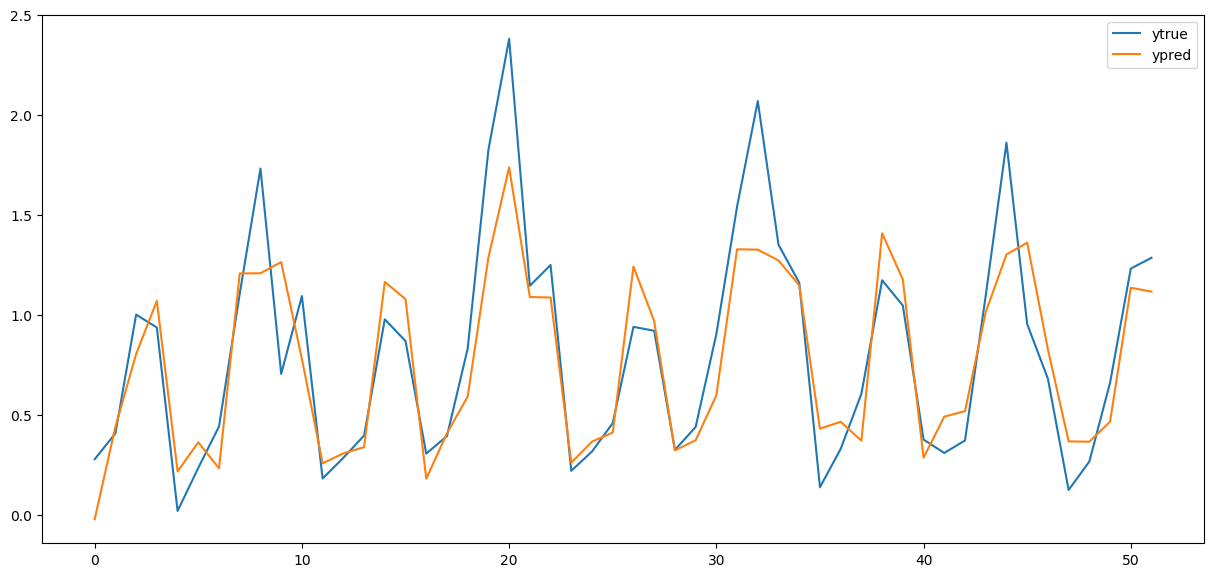

In [9]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

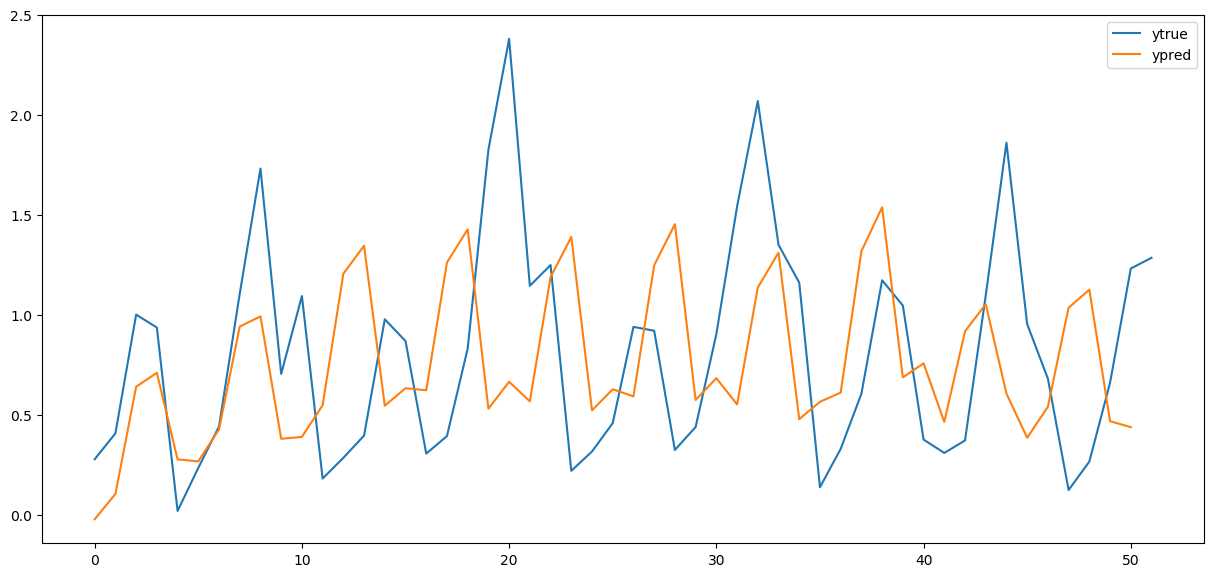

In [10]:
ypred = eval_model(svm, xtest.iloc[0], 50)
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import *

np.random.seed(7)
model = Sequential()
model.add(Dense(units=16, activation='tanh', input_dim=lag))
model.add(Dense(units=1, activation='linear'))
#opt = SGD(lr=0.01, momentum=0.2, decay=0.01)
opt = Adam(lr=0.01, decay=0.01)
model.compile(loss='mse',
              optimizer=opt)

model.fit(xtrain, ytrain, epochs=100, batch_size=64, verbose=0, shuffle=False);
ypred = model.predict(xtest)

Using CNTK backend


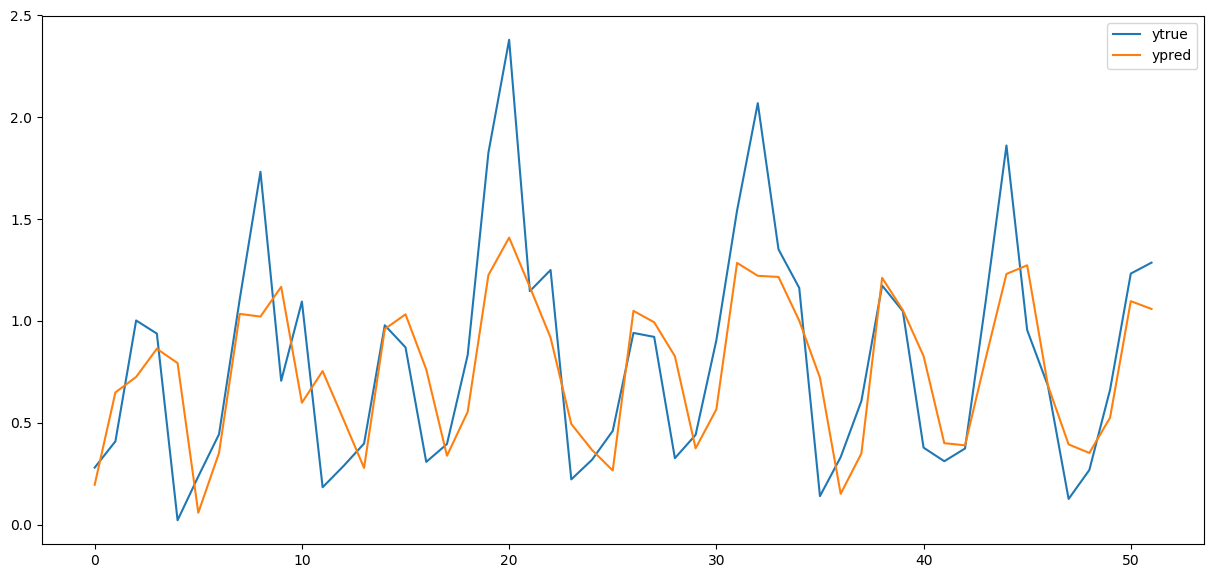

In [12]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [13]:
mse = mean_squared_error(ytest, ypred)
print(mse)

0.12689155125527696


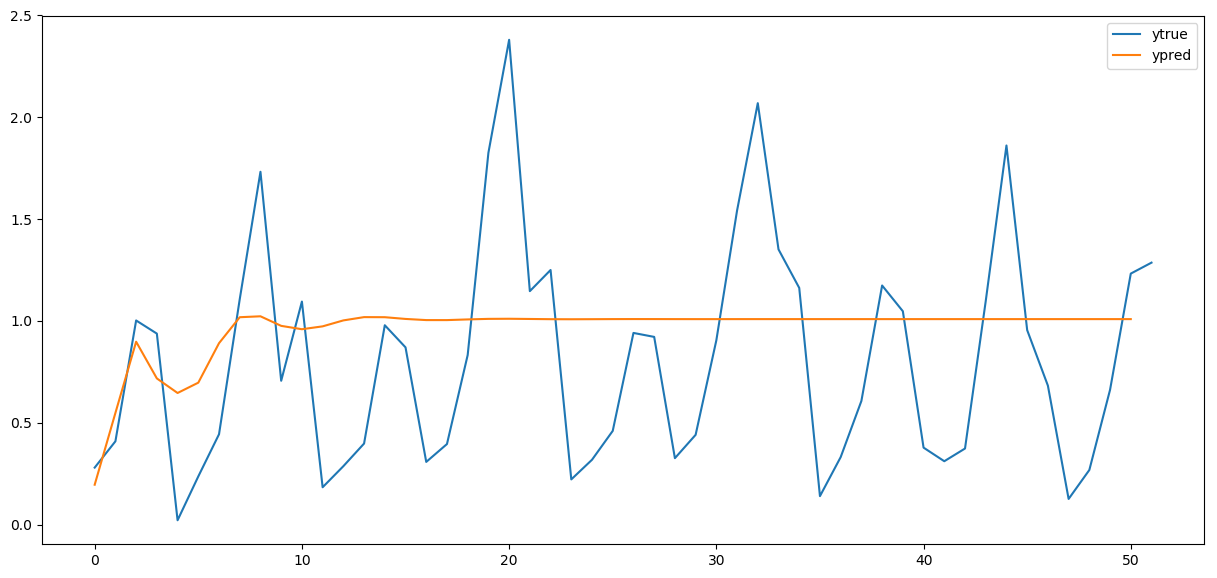

In [14]:
ypred=eval_model(model, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [15]:
from sklearn.neural_network import MLPRegressor

np.random.seed(10)
regresor = MLPRegressor(hidden_layer_sizes=(10,10,8), activation='tanh', solver='lbfgs', shuffle=False, max_iter=100)
regresor.fit(xtrain, ytrain)
score = regresor.score(xtest, ytest)
ypred = regresor.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print('score:{}\nmse:{}'.format(score, mse))

score:0.7267581782597807
mse:0.08046861774538215


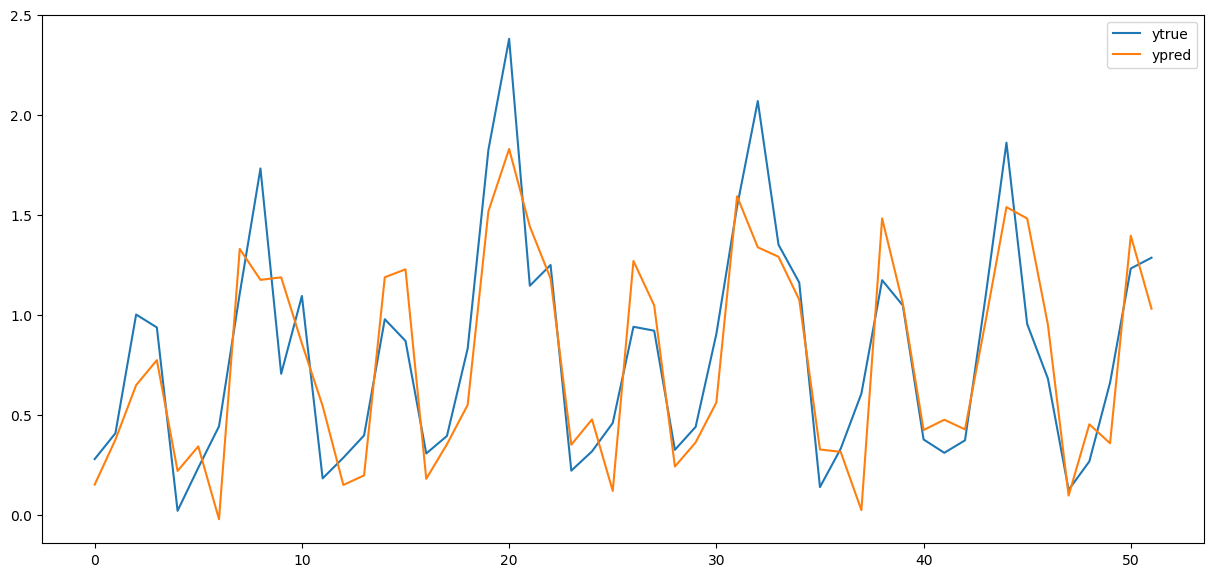

In [16]:
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

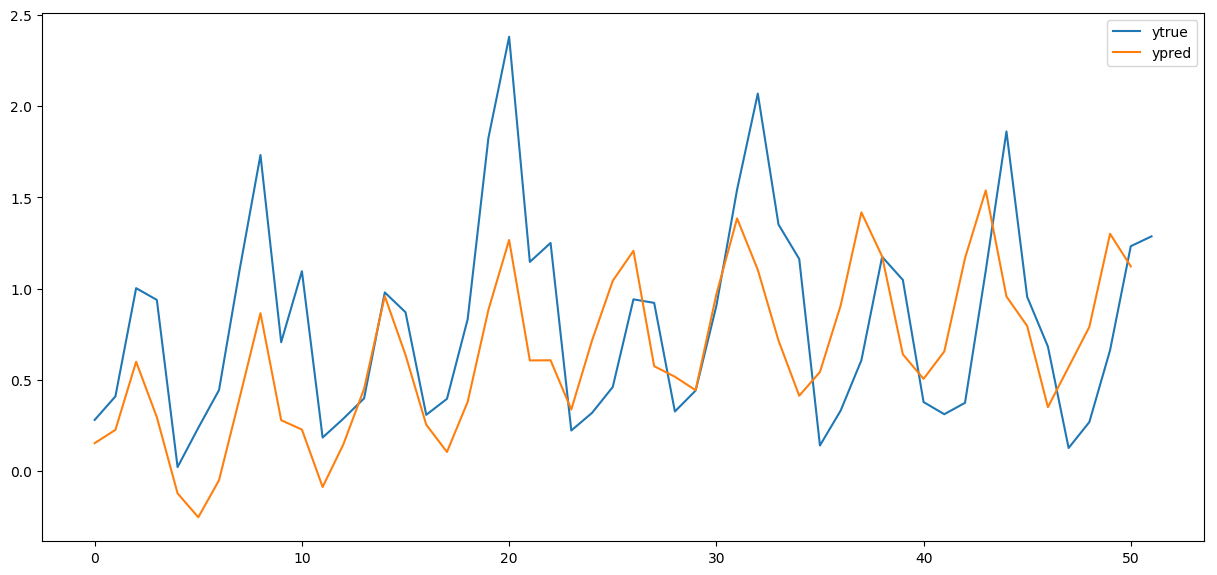

In [17]:
ypred=eval_model(regresor, xtest.iloc[0], 50).reshape([-1])
fig, ax = plt.subplots(1, figsize=(15,7), dpi=100)
plt.plot(ytest.values, label='ytrue')
plt.plot(ypred, label='ypred')
plt.legend()
plt.show()

In [20]:
ytest

472    0.280038
473    0.409099
474    1.002457
475    0.937952
476    0.021486
477    0.236748
478    0.443761
479    1.106956
480    1.732490
481    0.706293
482    1.095307
483    0.183501
484    0.286903
485    0.398164
486    0.979039
487    0.870412
488    0.307947
489    0.395655
490    0.832734
491    1.825693
492    2.380532
493    1.146432
494    1.250223
495    0.222089
496    0.318576
497    0.460291
498    0.941236
499    0.921770
500    0.326304
501    0.440938
502    0.905100
503    1.542214
504    2.069335
505    1.351441
506    1.162276
507    0.139928
508    0.331512
509    0.607296
510    1.174154
511    1.047791
512    0.378084
513    0.311344
514    0.373684
515    1.097596
516    1.861559
517    0.955080
518    0.682469
519    0.126128
520    0.268332
521    0.662139
522    1.232578
523    1.286397
Name: consumo, dtype: float64